<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Major Neural Network Architectures Challenge
## *Data Science Unit 4 Sprint 3 Challenge*

In this sprint challenge, you'll explore some of the cutting edge of Data Science. This week we studied several famous neural network architectures: 
recurrent neural networks (RNNs), long short-term memory (LSTMs), convolutional neural networks (CNNs), and Generative Adverserial Networks (GANs). In this sprint challenge, you will revisit these models. Remember, we are testing your knowledge of these architectures not your ability to fit a model with high accuracy. 

__*Caution:*__  these approaches can be pretty heavy computationally. All problems were designed so that you should be able to achieve results within at most 5-10 minutes of runtime on Colab or a comparable environment. If something is running longer, doublecheck your approach!

## Challenge Objectives
*You should be able to:*
* <a href="#p1">Part 1</a>: Train a RNN classification model
* <a href="#p2">Part 2</a>: Utilize a pre-trained CNN for objective detection
* <a href="#p3">Part 3</a>: Describe the difference between a discriminator and generator in a GAN
* <a href="#p4">Part 4</a>: Describe yourself as a Data Science and elucidate your vision of AI

<a id="p1"></a>
## Part 1 - RNNs

Use an RNN to fit a multi-class classification model on reuters news articles to distinguish topics of articles. The data is already encoded properly for use in an RNN model. 

Your Tasks: 
- Use Keras to fit a predictive model, classifying news articles into topics. 
- Report your overall score and accuracy

For reference, the [Keras IMDB sentiment classification example](https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py) will be useful, as well the RNN code we used in class.

__*Note:*__  Focus on getting a running model, not on maxing accuracy with extreme data size or epoch numbers. Only revisit and push accuracy if you get everything else done!

In [33]:
# Utilities
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# LSTM RNN
from tensorflow.keras.datasets import reuters
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

# CNN
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import tensorflow as tf
import tensorflow_hub as hub

In [29]:
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

In [30]:
# Demo of encoding

word_index = reuters.get_word_index(path="reuters_word_index.json")

print(f"Iran is encoded as {word_index['iran']} in the data")
print(f"London is encoded as {word_index['london']} in the data")
print("Words are encoded as numbers in our dataset.")

Iran is encoded as 779 in the data
London is encoded as 544 in the data
Words are encoded as numbers in our dataset.


In [20]:
max_features = 10_000  # equivalent to num_words in `reuters.load_data()`
max_length = 120  # number of chars per sequence
batch_size = 32

# Reshape/pad sequences for use in model training and testing
x_train = sequence.pad_sequences(x_train, maxlen=max_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_length)

print('Training sequences: ', len(x_train))
print('Testing  sequences: ',  len(x_test))
print('-- BUILD MODEL --')

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

print('-- MODEL BUILD SUCCESSFUL --')

Training sequences:  8982
Testing  sequences:  2246
-- BUILD MODEL --
-- MODEL BUILD SUCCESSFUL --


In [21]:
print('-- FIT MODEL --')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          validation_data=(x_test, y_test))

print('-- EVALUATE MODEL --')
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score: ', score)
print('Test accuracy: ', acc)

-- FIT MODEL --
Train on 8982 samples, validate on 2246 samples
Epoch 1/10
8982/8982 [==============================] - 55s 6ms/step - loss: 146.0959 - acc: 0.0480 - val_loss: 146.8376 - val_acc: 0.0467
Epoch 2/10
8982/8982 [==============================] - 54s 6ms/step - loss: 145.8340 - acc: 0.0481 - val_loss: 146.8375 - val_acc: 0.0467
Epoch 3/10
8982/8982 [==============================] - 55s 6ms/step - loss: 145.8339 - acc: 0.0481 - val_loss: 146.8375 - val_acc: 0.0467
Epoch 4/10
8982/8982 [==============================] - 55s 6ms/step - loss: 145.8339 - acc: 0.0481 - val_loss: 146.8375 - val_acc: 0.0467
Epoch 5/10
8982/8982 [==============================] - 56s 6ms/step - loss: 145.8339 - acc: 0.0481 - val_loss: 146.8375 - val_acc: 0.0467
Epoch 6/10
8982/8982 [==============================] - 57s 6ms/step - loss: 145.8339 - acc: 0.0481 - val_loss: 146.8375 - val_acc: 0.0467
Epoch 7/10
8982/8982 [==============================] - 54s 6ms/step - loss: 145.8339 - acc: 0.0481 - 

Conclusion - RNN runs, and gives pretty decent improvement over a naive model. To *really* improve the model, more playing with parameters would help. Also - RNN may well not be the best approach here, but it is at least a valid one.

<a id="p2"></a>
## Part 2- CNNs

### Find the Frog

Time to play "find the frog!" Use Keras and ResNet50 (pre-trained) to detect which of the following images contain frogs:

<img align="left" src="https://d3i6fh83elv35t.cloudfront.net/newshour/app/uploads/2017/03/GettyImages-654745934-1024x687.jpg" width=400>


In [37]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()
arguments = {"keywords": "animal pond", "limit": 10, "print_urls": True}
absolute_image_paths = response.download(arguments)


Item no.: 1 --> Item name = animal pond
Evaluating...
Starting Download...
Image URL: https://www.enchantedlearning.com/pgifs/Pondanimals.GIF
Completed Image ====> 1.Pondanimals.GIF
Image URL: https://i.ytimg.com/vi/NCbu0TND9vE/hqdefault.jpg
Completed Image ====> 2.hqdefault.jpg
Image URL: https://pklifescience.com/staticfiles/articles/images/PKLS4116_inline.png
Completed Image ====> 3.PKLS4116_inline.png
Image URL: https://get.pxhere.com/photo/water-animal-pond-wildlife-mammal-fish-eat-fauna-whiskers-vertebrate-otter-mink-marmot-sea-otter-mustelidae-1383482.jpg
Completed Image ====> 4.water-animal-pond-wildlife-mammal-fish-eat-fauna-whiskers-vertebrate-otter-mink-marmot-sea-otter-mustelidae-1383482.jpg
Image URL: https://pklifescience.com/staticfiles/articles/images/PKLS4116.png
Completed Image ====> 5.PKLS4116.png
Image URL: https://i.pinimg.com/originals/57/5c/5b/575c5b5c441e27ff04eb50571ee30127.jpg
Completed Image ====> 6.575c5b5c441e27ff04eb50571ee30127.jpg
Image URL: https://cdn

At time of writing at least a few do, but since the Internet changes - it is possible your 5 won't. You can easily verify yourself, and (once you have working code) increase the number of images you pull to be more sure of getting a frog. Your goal is to validly run ResNet50 on the input images - don't worry about tuning or improving the model.

*Hint* - ResNet 50 doesn't just return "frog". The three labels it has for frogs are: `bullfrog, tree frog, tailed frog`

*Stretch goal* - also check for fish.

In [31]:
def process_img_path(img_path):
    return image.load_img(img_path, target_size=(224,224))

def img_contains_objects(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    model = ResNet50(weights='imagenet')
    features = model.predict(x)
    results = decode_predictions(features, top=3)[0]
    return results

module = hub.Module('https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1')
height, width = hub.get_expected_image_size(module)
image_dir = 'downloads/animal_pond/'

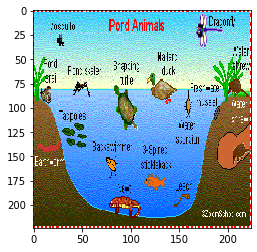

[('n03598930', 'jigsaw_puzzle', 0.86803216), ('n06359193', 'web_site', 0.06409987), ('n02834397', 'bib', 0.021264244)]


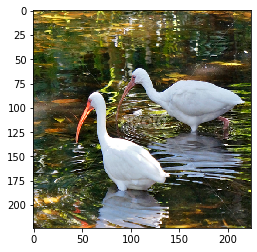

[('n02009912', 'American_egret', 0.7822409), ('n02012849', 'crane', 0.14339279), ('n02009229', 'little_blue_heron', 0.021143379)]


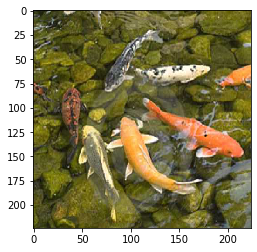

[('n01443537', 'goldfish', 0.8495876), ('n01631663', 'eft', 0.06760155), ('n02536864', 'coho', 0.03516345)]


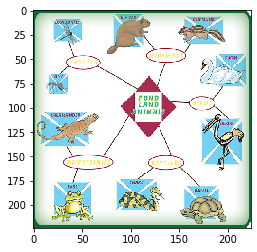

[('n04243546', 'slot', 0.87124354), ('n04476259', 'tray', 0.04993661), ('n03908618', 'pencil_box', 0.023072658)]


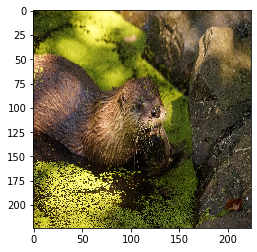

[('n02442845', 'mink', 0.30976495), ('n02363005', 'beaver', 0.23398927), ('n02361337', 'marmot', 0.20796894)]


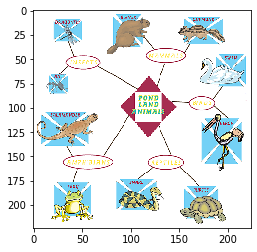

[('n03485794', 'handkerchief', 0.88227266), ('n02834397', 'bib', 0.022680892), ('n03291819', 'envelope', 0.020095173)]


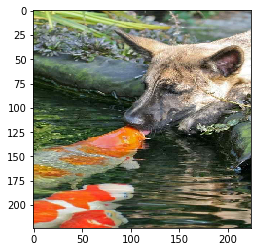

[('n02116738', 'African_hunting_dog', 0.61015844), ('n02105162', 'malinois', 0.19866702), ('n02114712', 'red_wolf', 0.051153023)]


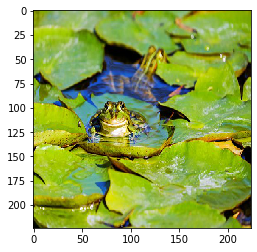

[('n01737021', 'water_snake', 0.30730668), ('n01641577', 'bullfrog', 0.26061186), ('n04275548', 'spider_web', 0.11343444)]


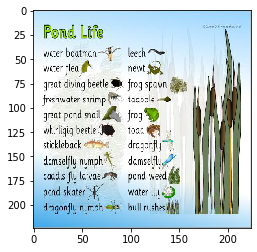

[('n06359193', 'web_site', 0.5092326), ('n02840245', 'binder', 0.10986995), ('n04209239', 'shower_curtain', 0.10011923)]


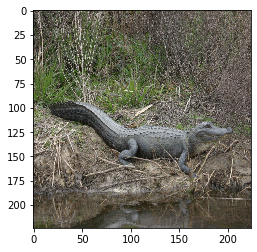

[('n01698640', 'American_alligator', 0.96394134), ('n01697457', 'African_crocodile', 0.026759809), ('n01737021', 'water_snake', 0.005964683)]


In [39]:
for file in os.listdir(image_dir):
    plt.imshow(process_img_path(image_dir+file))
    plt.show();
    print(img_contains_objects(process_img_path(image_dir+file)))

<a id="p3"></a>
## Part 3 - Generative Adverserial Networks (GANS)

Describe the difference between a discriminator and generator in a GAN in your own words.

-----------
The descriminator and generator are the adversaries referenced in the name "GAN". Here, as adversaries, their activity can be considered a zero-sum game in a game-theoretic sense. The descriminator is trained on unlabeled data and the generator is initialized with random noise- not training data. The game here is for the generator to improve its output over epochs via an update function until the descriminator is "tricked" into being unable to distinguish the generator's output from the training data.

<a id="p4"></a>
## Part 4 - More...

Answer the following questions, with a target audience of a fellow Data Scientist:

- **What do you consider your strongest area, as a Data Scientist?**
Personally, I think my strongest skill as a data scientist is my experience with many different types of programming- preferring to be a "T-shaped" generalist. I always try to incorporate software engineering best practices and write the absolute simplest software required to meet project requirements. In short, my strongest area as a data scientist is the ability to take DS techniques and apply best practices & domain expertise to write software/models that tend to be more readable, maintainable, and stable. 

- **What area of Data Science would you most like to learn more about, and why?**
I'd like to learn absolutely as much as I can about (big) data engineering. This field is highly interdisciplinary and requires working knowledge of many different aspects of CS. This includes distributed systems, database design, information theory, coding theory, S.E. best practices, productionizing models, DS/ML/AI, and the list goes on. This doesn't even include any of the myriad of tools available for a modern data pipeline system. I'd also like to spend more time increasing my proficiency in Scala.
   
- **Where do you think Data Science will be in 5 years?**
I think that DS is in a state that frontend was in before 2010/the creation of React/Vue. To quote a podcast, back then frontend was considered a "sort of backwater" of SE. The tooling was inadequate, leading to a world of frustrations and lack of recognition as a true field of SE. After React this all changed: now frontend isn't even questioned as being a systems-oriented SE field, even though UI/UX are involved. I think DS is currently in the "backwater" stage. Many project managers/business leaders say that a majority of DS projects end up failing or not delivering any value. There are more than a few glaring pain points between data scientists and data engineers and production data science. We currently have a plethora of opinionated tools for different niches of the field, but there's still something missing similar to React... A tool with sufficient robustness/necessary complexity to meet the engineering challenges of the field as well as usher in a new paradigm/workflow standard with which most data scientists can use to create more *successful* projects.

- **What are the threats posed by AI to our society?**
The obvious threat posed is the displacement of labor forces globally for a wide gamut of industries. I don't think UBI is close to the right solution: work is too engrained into the human condition to garner a positive outcome for possibly millions of people who wouldn't/couldn't work for a living, in my humble opinion. Since the times of nomadic cave people there have been roles, responsibilites, and duties required of people. The advent of currency certainly bolstered this requirement to work, and nowadays a great majority of people even consider their jobs to be an integral aspect of their _identity_. I suppose I'm trying to say that our society and culture has yet to advance to the point where not being gainfully employed can be seen as an acceptable path, and then also to use that collective "free time" to do actual good works.
   
- **How do you think we can counteract those threats?** 
My only proposed solution is to not develop more machines of workforce automation, but instead to develop tools of workforce augmentation. Elon Musk's Neuralink is the closest product I can think of to this concept. Instead of replacing the *still useful* human brains with machines that are likely to only be able to perform a handful of tasks, retain the human but also give them the powers of AI to boost efficiency or whatever the use case might be. Don't replace the people, because this will also lead to higher economic disparity, instead invest in the people and collectively raise the bar for human abilities across the globe. I think this pie-in-the-sky thinking, but still better than UBI.
   
- **Do you think achieving General Artifical Intelligence is ever possible?**
Yes! I try not to put barriers on the capbilities of humankind, so 100% yes I do believe that it is possible. Maybe during this current AI renaissance we will stumble upon an architecture that enables AGI, but maybe like the 1950's it'll require so much data and so much compute that we won't currently be able to pursue it. There's an idea that there are levels of advancement for civilizations, and one of the milestones is harnessing the power of a local star. I'm just postulating, but maybe the energy required to create an AGI would require more energy than our current technology level can produce. I don't think this is too crazy of an idea if one considers how much energy it takes for a toddler's brain to be able to detect dogs compared to a neural network algorithm. This is only the most fundamental level of AI too, so I think AGI will likely require more energy and compute power than we can currently afford. 

A few sentences per answer is fine - only elaborate if time allows.

## Congratulations! 

Thank you for your hard work, and congratulations! You've learned a lot, and you should proudly call yourself a Data Scientist.


In [40]:
from IPython.display import HTML

HTML("""<iframe src="https://giphy.com/embed/26xivLqkv86uJzqWk" width="480" height="270" frameBorder="0" class="giphy-embed" allowFullScreen></iframe><p><a href="https://giphy.com/gifs/mumm-champagne-saber-26xivLqkv86uJzqWk">via GIPHY</a></p>""")